Apply basic analysis and visualization on the features.

First some library imports and data loading functions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import random

TEMP_LOW_LIMIT = -459.67
TEMP_HIGH_LIMIT = 1000
RPM_LOW_LIMIT = 0
RPM_HIGH_LIMIT = 6e8  # the largest achieved rpm of all human artifacts
Y_LIMS = {
    'rpm': (-20, 1500),
    'motor_voltage': (0, 400),
    'motor_current': (-20, 100),
    'motor_temp': (-20, 250),
    'inlet_temp': (-20, 250),
}

In [2]:
def exclude_physical_anml(df):
    result = df[(df['motor_temp'] > TEMP_LOW_LIMIT) & (df['inlet_temp'] > TEMP_LOW_LIMIT) & (df['rpm'] > 0) & (df['rpm'] < RPM_HIGH_LIMIT)]
    return result

def load_file(unit, file_type='rms', anomaly=True):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    if anomaly == False:
        file_name = '../data/processed/train/unit{}_{}_anomaly_excluded.csv'.format(unit_name, file_type)
    else:
        file_name = '../data/raw/train/unit{}_{}.csv'.format(unit_name, file_type)
    df = pd.read_csv(file_name, index_col=0)
    return df

Plot the feature value trend with time in a single unit.

In [3]:
def plot_feature_in_single_file(feature_name, unit, bins=20):
    file_df = pd.read_csv("../data/raw/train/unit{}_rms.csv".format(unit))
    file_df = exclude_physical_anml(file_df)
    file_df['timestamp'] = pd.to_datetime(file_df['timestamp'])
    file_df.set_index('timestamp', inplace=True)

    sns.set()
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    ax1 = fig.add_subplot(211)
    file_df[feature_name].plot(ylim=Y_LIMS[feature_name])
    ax2 = fig.add_subplot(212)
    sns.distplot(file_df[feature_name], bins=bins)
    plt.show()

Feature rpm of unit 0010

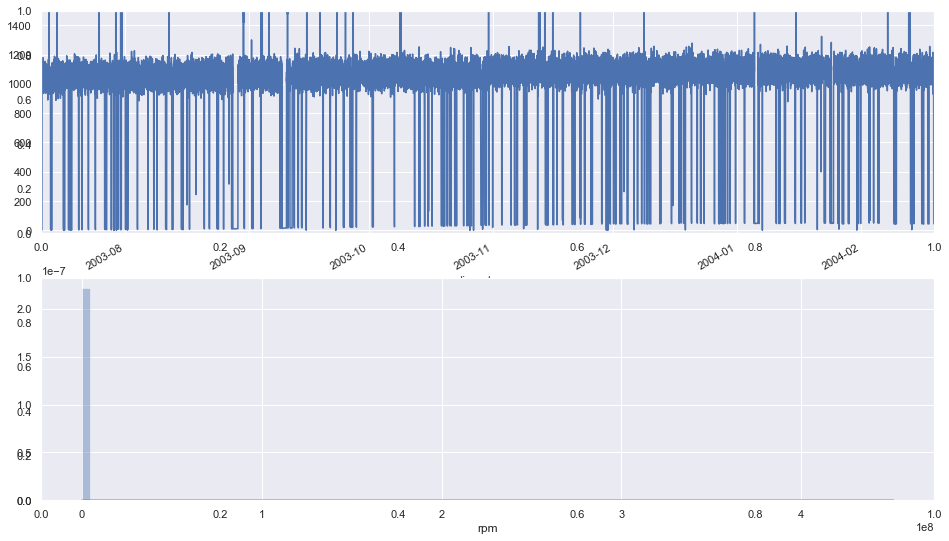

In [30]:
plot_feature_in_single_file("rpm", "0010", bins=100)

Feature "motor_voltage" of unit 0010

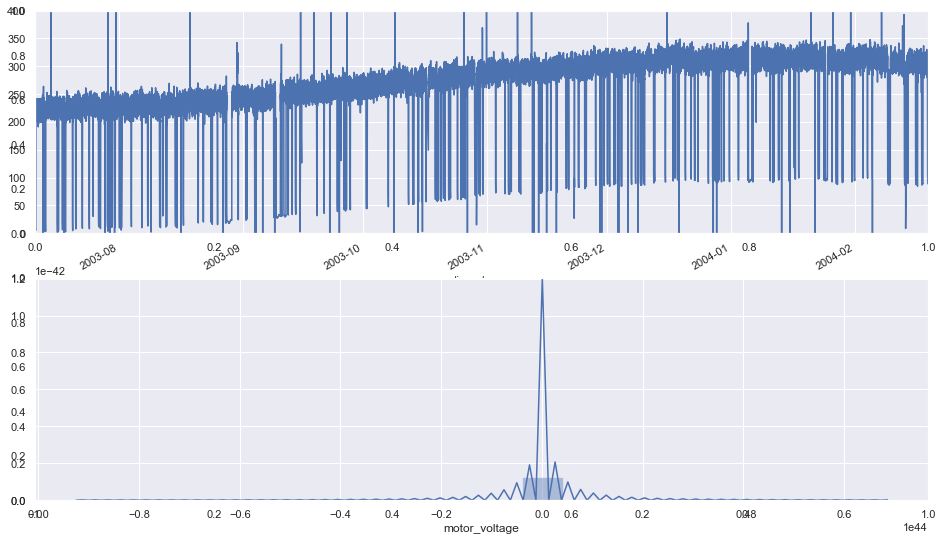

In [31]:
plot_feature_in_single_file("motor_voltage", "0010")

Feature "motor_current" of unit 0017

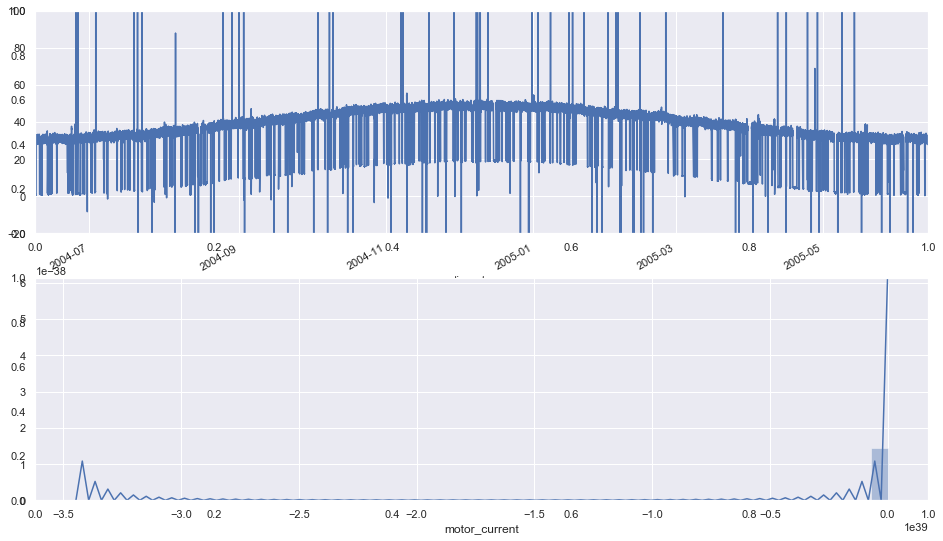

In [32]:
plot_feature_in_single_file("motor_current", "0017", bins=50)

Feature "motor_temp" of unit 0017

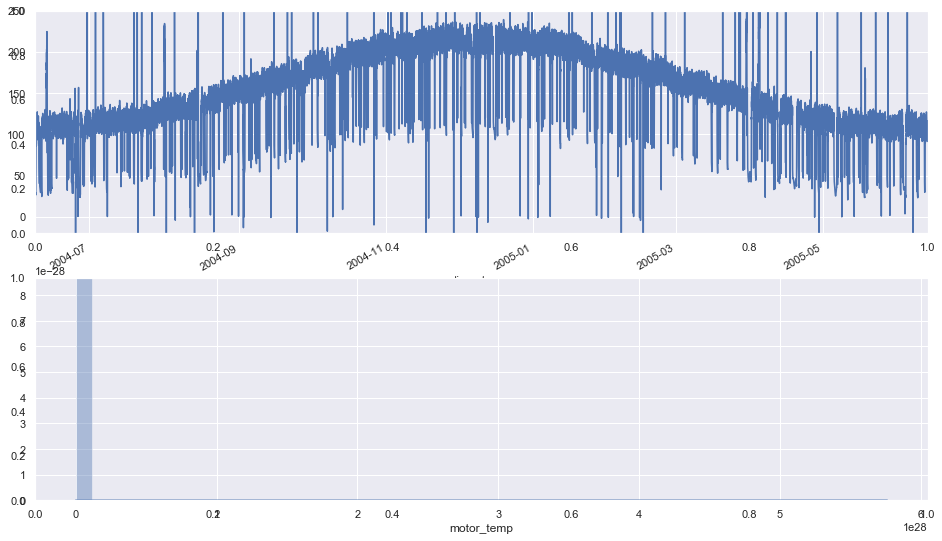

In [33]:
plot_feature_in_single_file("motor_temp", "0017", bins=50)

Feature "inlet_temp" of unit 0017

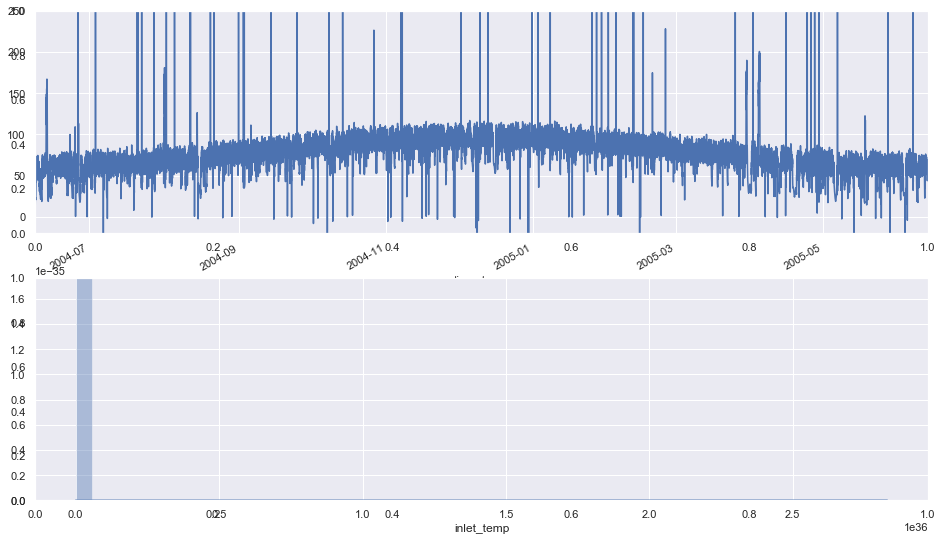

In [34]:
plot_feature_in_single_file("inlet_temp", "0017", bins=50)

Take a look at the feature value trend with time in different units.

In [4]:
def peek_attributes_trend(attribute, ylim_low=None, ylim_high=None):
    units = ["000{}".format(num) if num < 10 else "00{}".format(num) for num in random.sample(range(0, 20), 9)]
    file_names = ["../data/raw/train/unit{}_rms.csv".format(unit) for unit in units]
    sns.set()
    f, axs = plt.subplots(3, 3, figsize=(20, 12))
    for idx, file_name in enumerate(file_names):
        file_df = pd.read_csv(file_name)
        file_df = exclude_physical_anml(file_df)
        file_df['timestamp'] = pd.to_datetime(file_df['timestamp'])
        file_df.set_index('timestamp', inplace=True)
        
        ax1 = plt.subplot(3, 3, idx + 1)
        if ylim_low is not None or ylim_high is not None:
            file_df[attribute].plot(ylim=(ylim_low, ylim_high))
        else:
            file_df[attribute].plot(ylim=Y_LIMS[attribute])
    plt.show()

Rpm trend with time in different unit files. Before excluding anomalies, the rpm values vary enormously.

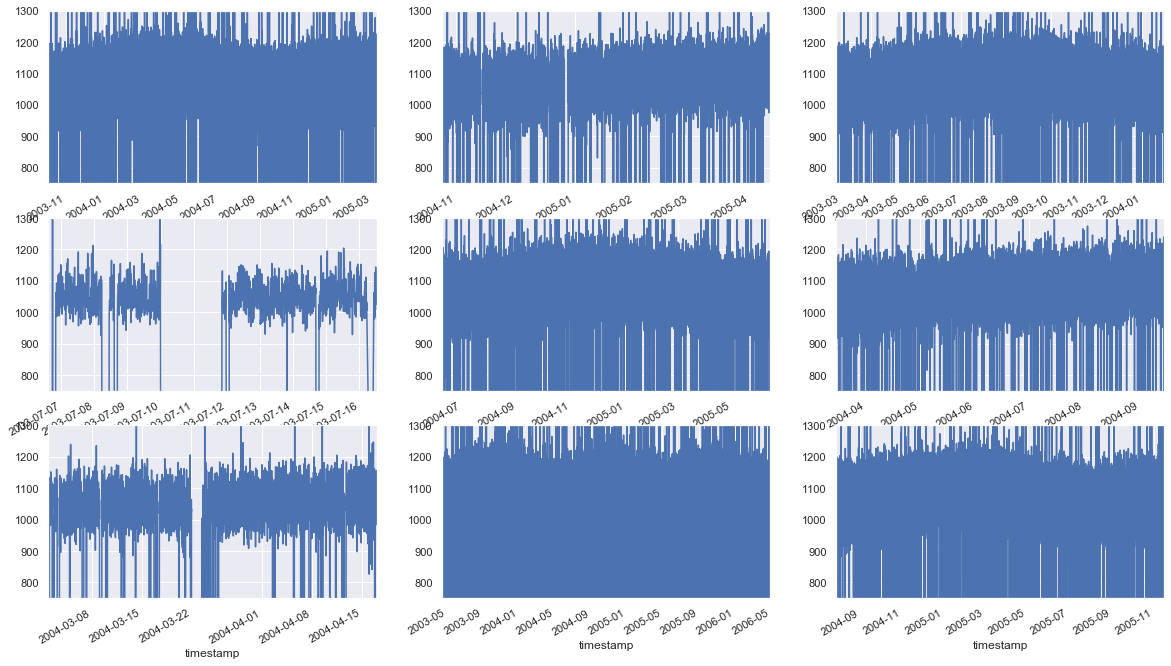

In [5]:
peek_attributes_trend('rpm', ylim_low=750, ylim_high=1300)

Motor_voltage trend with time in different unit files.

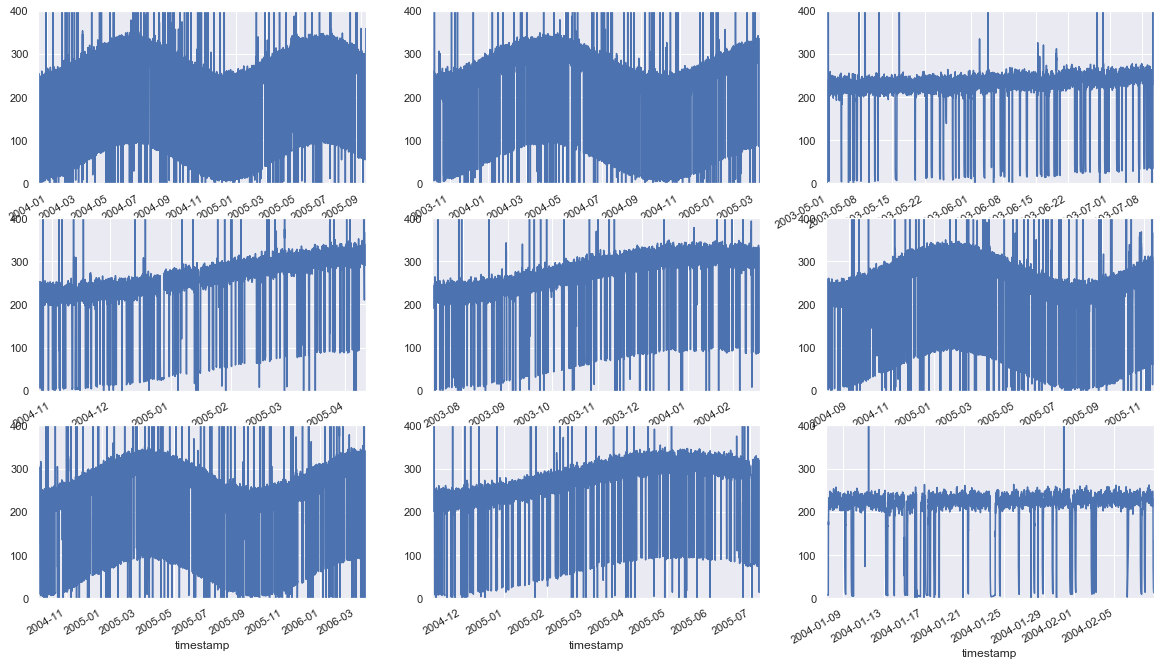

In [6]:
peek_attributes_trend('motor_voltage')

Motor_current trend with time in different unit files.

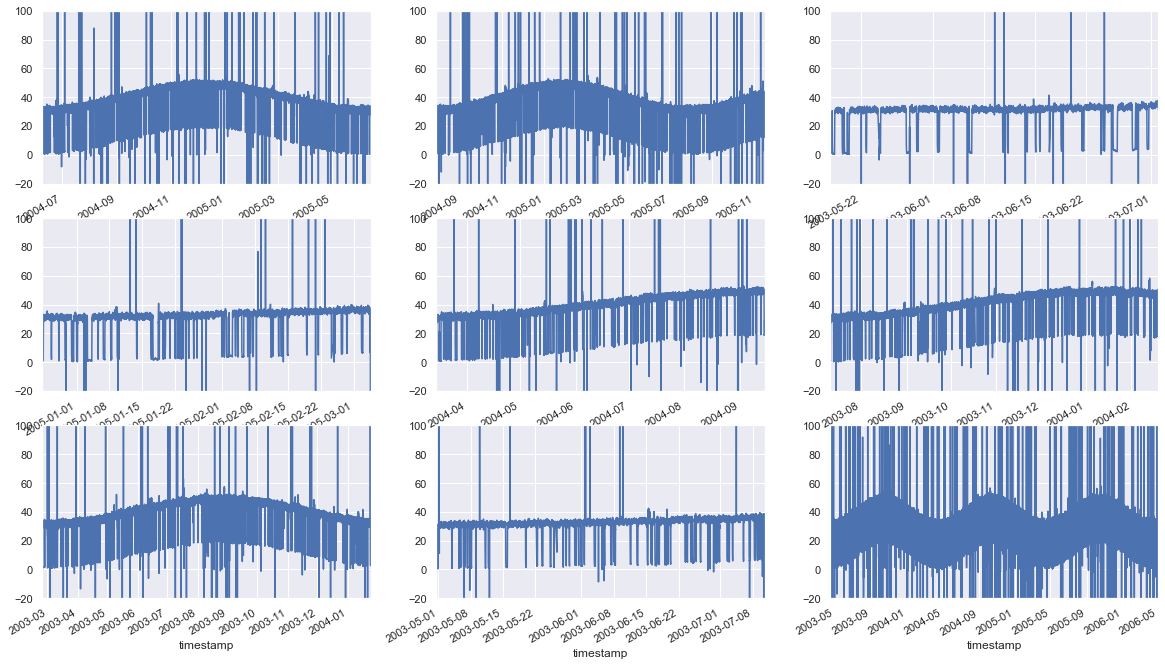

In [7]:
peek_attributes_trend('motor_current')

Motor_temp trend with time in different unit files.

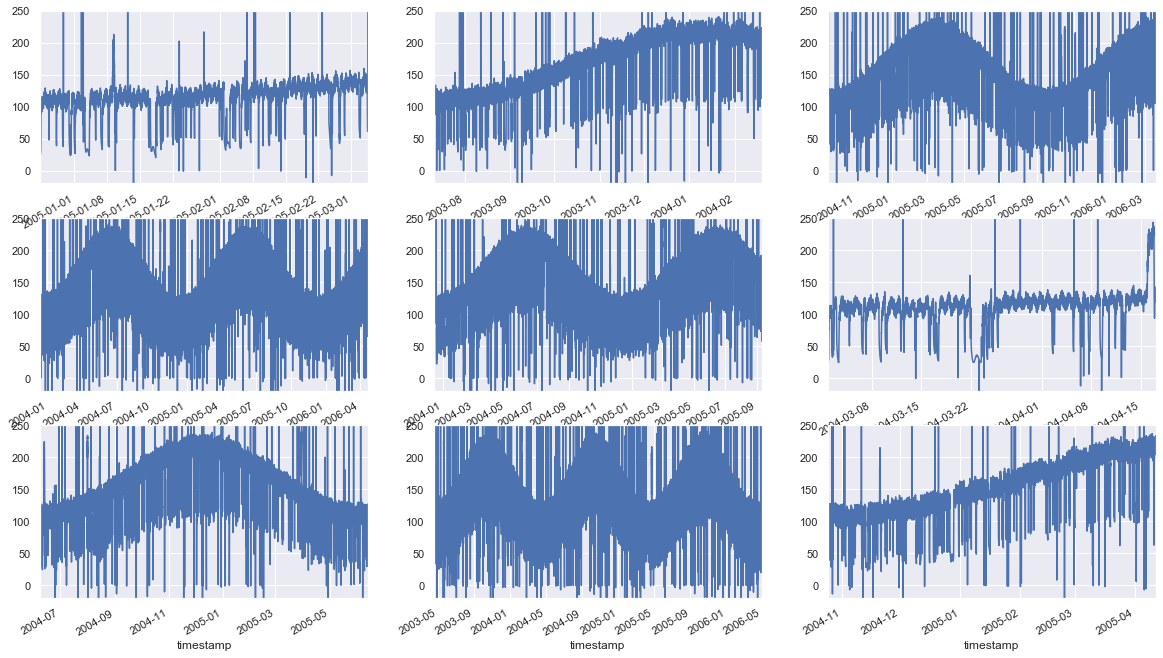

In [8]:
peek_attributes_trend('motor_temp')

Inlet_temp trend with time in different unit files.

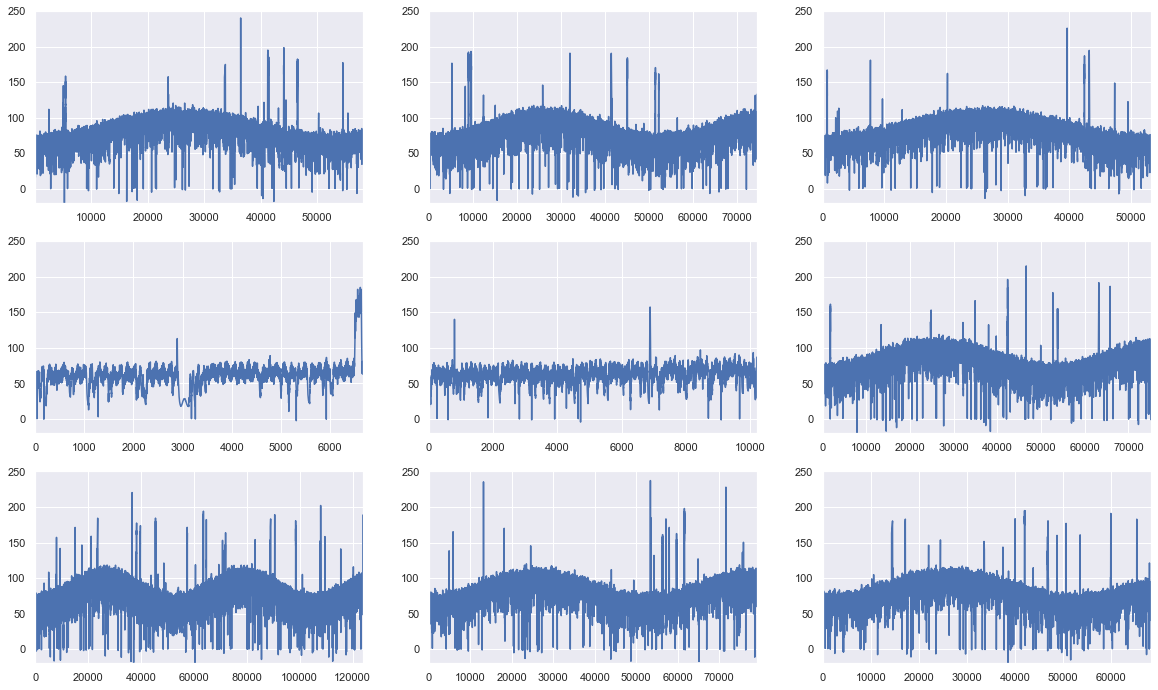

In [118]:
peek_attributes_trend('inlet_temp', ylim_low=-20, ylim_high=250)

Plot and compare value distributions of feature "rpm" in all files.

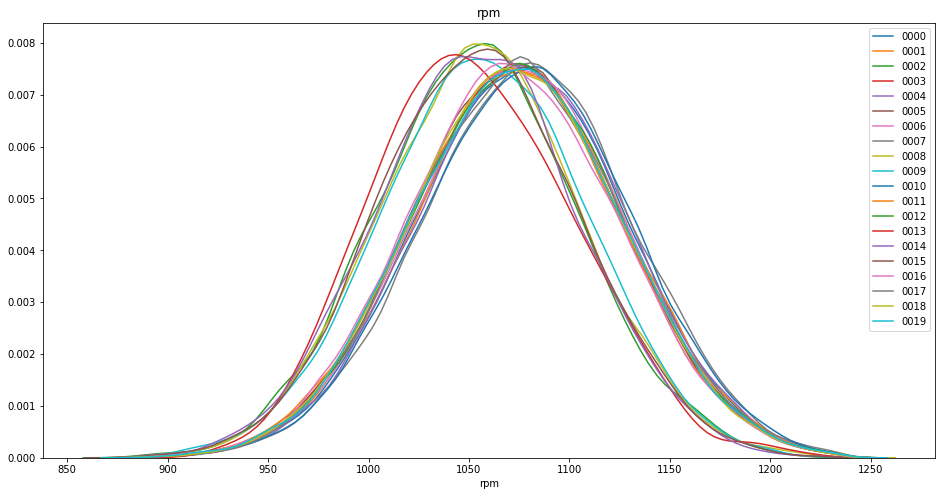

In [24]:
def plot_feature_dist_in_all_files(feature_name, bins=50):
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.title(feature_name)
    for unit in range(0, 20):
        unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
        df = pd.read_csv('../data/processed/train/unit{}_rms_anomaly_excluded.csv'.format(unit_name))
        sns.distplot(df[feature_name], bins=bins, hist=False, label=unit_name)
    plt.show()
plot_feature_dist_in_all_files('rpm')

Plot and compare value distributions of feature "motor_voltage" in all files.

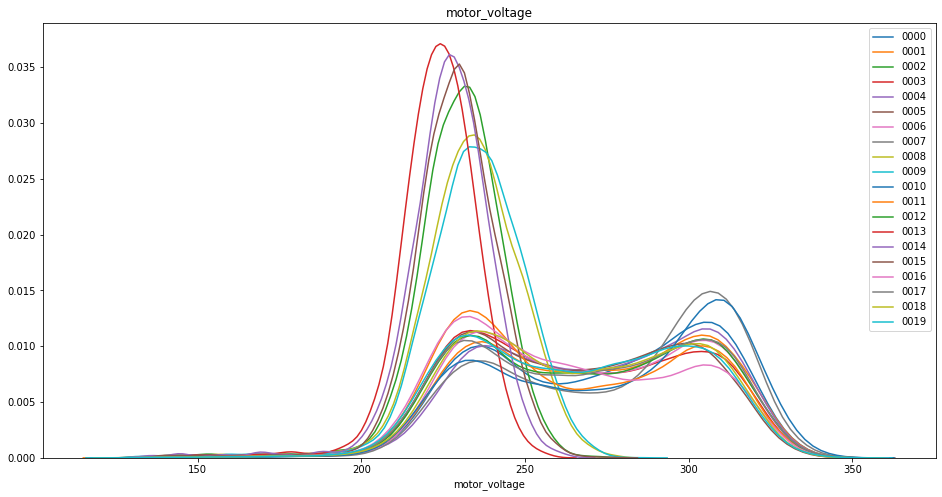

In [25]:
plot_feature_dist_in_all_files('motor_voltage')

Plot and compare value distributions of feature "motor_current" in all files.

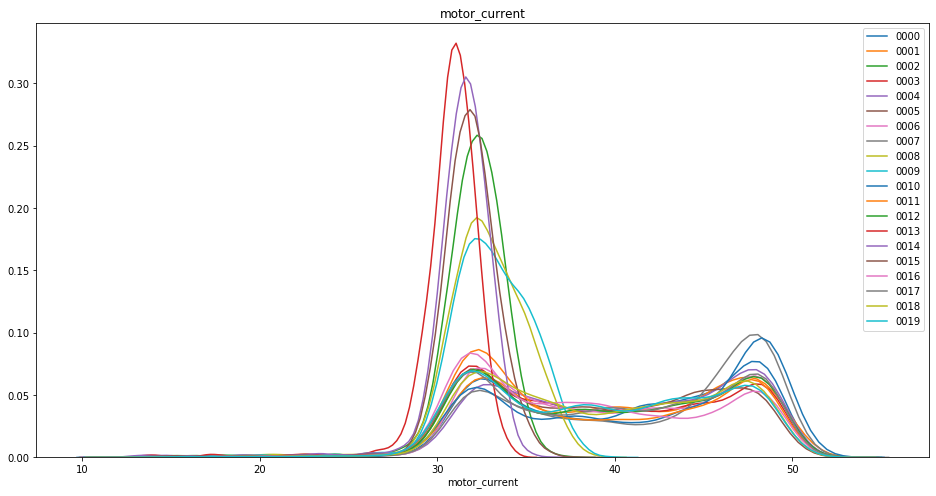

In [26]:
plot_feature_dist_in_all_files('motor_current')

Plot and compare value distributions of feature "motor_temp" in all files.

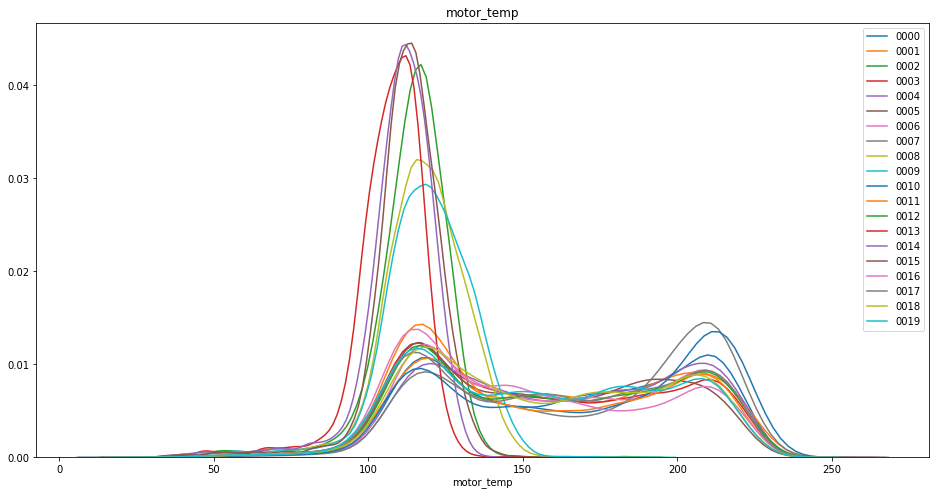

In [27]:
plot_feature_dist_in_all_files('motor_temp')

Plot and compare value distributions of feature "inlet_temp" in all files.

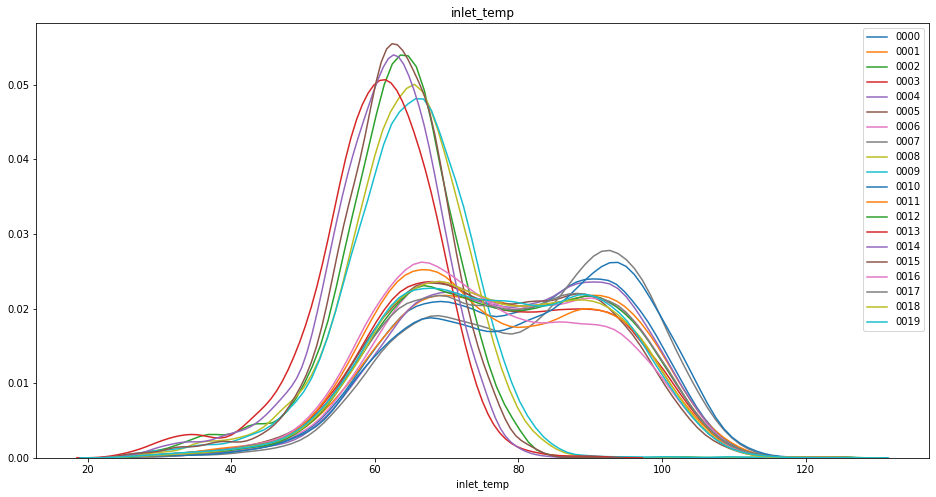

In [28]:
plot_feature_dist_in_all_files('inlet_temp')

An obvious pattern observed here is that in every feature, there're 2 groups of distribution pattern existing in all units. This takes us to an initiative of clustering attempts.

Before clustering, let's take a look at the Pearson correlations between features in several units.

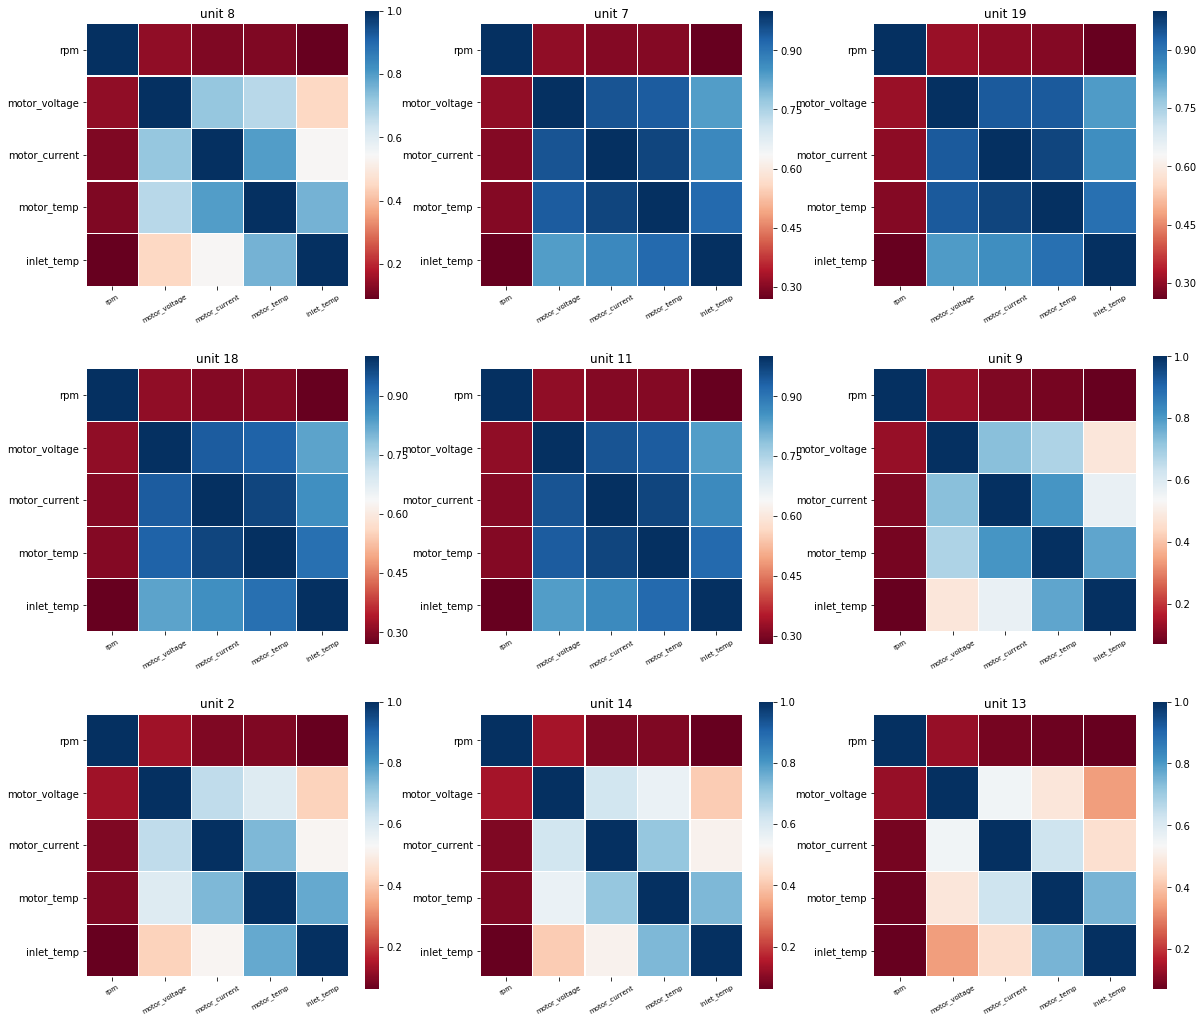

In [59]:
colormap = plt.cm.RdBu
f, axs = plt.subplots(3, 3, figsize=(20, 18))
for idx, unit in enumerate(random.sample(range(0, 20), 9)):
    df_unit = load_file(unit, file_type='rms', anomaly=False)
    ax = plt.subplot(3, 3, idx + 1)
    plt.title("unit {}".format(unit))
    sns.heatmap(df_unit.corr(method='pearson', min_periods=1).round(decimals=2),
            linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
    plt.xticks(rotation=30, fontsize=7)

plt.show()

It can be observed that the feature "rpm" is quite separate from all other features, while "motor_voltage", "motor_current", "motor_temp" and "inlet_temp" are somewhat correlated in most units.